In [16]:
from sklearn.datasets import make_circles
import numpy as np
import torch
import torch.nn as nn
import pandas as pd
import torchmetrics

import torch.nn as nn
import matplotlib.pyplot as plt

# Split data into train and test sets
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_blobs

# for timing computations
import time

import os    
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

### Plots

In [3]:
def plot_decision_boundary(model: torch.nn.Module, X: torch.Tensor, y: torch.Tensor):
    """Plots decision boundaries of model predicting on X in comparison to y.

    Source - https://madewithml.com/courses/foundations/neural-networks/ (with modifications)
    """
    # Put everything to CPU (works better with NumPy + Matplotlib)
    model.to("cpu")
    X, y = X.to("cpu"), y.to("cpu")

    # Setup prediction boundaries and grid
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), np.linspace(y_min, y_max, 101))

    # Make features
    X_to_pred_on = torch.from_numpy(np.column_stack((xx.ravel(), yy.ravel()))).float()

    # Make predictions
    model.eval()
    with torch.inference_mode():
        y_logits = model(X_to_pred_on)

    # Test for multi-class or binary and adjust logits to prediction labels
    if len(torch.unique(y)) > 2:
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)  # mutli-class
    else:
        y_pred = torch.round(torch.sigmoid(y_logits))  # binary

    # Reshape preds and plot
    y_pred = y_pred.reshape(xx.shape).detach().numpy()
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

In [4]:
def plot_model_boundary(model, X_train, y_train, X_test, y_test):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.title("Train")
    plot_decision_boundary(model, X_train, y_train)
    plt.subplot(1, 2, 2)
    plt.title("Test")
    plot_decision_boundary(model, X_test, y_test) 

In [9]:
def plot_loss_accuracy_by_epochs(loss=None, accuracy=None):
    """
    Plot the loss and accuracy by epochs after traing the model.
    Parameters:
        loss (tuple): train loss followed by test loss. Ex.: (loss_train, loss_test)
        accuracy (tuple): train accuracy followed by test accuracy. Ex.: (acc_train, acc_test)
    """
    
    fig,ax = plt.subplots(1, 2, figsize=(16,5))
    if (loss is not None):
        ax[0].plot(loss[0], 's-', label='Train')
        ax[0].plot(loss[1], 's-', label='Test')
        ax[0].set_xlabel('Epochs')
        ax[0].set_ylabel('Loss')
        ax[0].set_title('Model loss')
        ax[0].legend()
        
    if (accuracy is not None):
        ax[1].plot(accuracy[0], 's-', label='Train')
        ax[1].plot(accuracy[1], 'o-', label='Test')
        ax[1].set_xlabel('Epochs')
        ax[1].set_ylabel('Accuracy (%)')
        ax[1].set_title(f'Final model test accuracy: {accuracy[1][-1]*100:.2f}%')
        ax[1].legend()

    plt.show()

In [77]:
def plot_metrics_by_epochs_old(dict_stats, overlay=None):
    """ Plot graph in subplots with some statitistics gather during the model training
        Args:
            dict_stats (dict): dictionary with stats as key and the list of stat computation as value
    """
    
    total_metrics = int(len(dict_stats))
    #total_subplots = 2
    #total_fig = int(np.ceil(total_metrics/total_subplots))
    fig, ax = plt.subplots(nrows=1, ncols=total_metrics, figsize=(10,4))
    fig.tight_layout(pad=3)
    
    for idx, metric in enumerate(dict_stats):
        values = dict_stats.get(metric)
        ax[idx].plot(values, 'o')
        ax[idx].plot(len(values), values[-1], 'ro')
        ax[idx].set_xlabel("Epcoch")
        ax[idx].set_ylabel(metric)
        metric_value = np.round(values[-1], 3)
        print(metric_value)
        ax[idx].set_title(f"Last {metric}: {metric_value}")
        ax[idx].grid()
    plt.show()
    
    # plot two or more metrics in the same chart
    if (overlay == "all"):
        overlay = list(training_stats.keys())
    else: 
        if not isinstance(overlay, list):
            overlay=None
        
    if (overlay is not None):
        plt.figure(figsize=(6, 4))
        for idx, metric in enumerate(overlay):
            value = dict_stats.get(metric)
            if (value is not None):
                plt.plot(dict_stats.get(metric))
        plt.xlabel("Epochs")
        print(",".join(overlay))
        plt.legend(overlay)
        plt.title(" vs. ".join(overlay))
        plt.show()

In [9]:
def plot_predictions(
    train_data,
    train_labels,
    test_data,
    test_labels,
    predictions=None
):
    plt.figure(figsize=(7, 5))
    plt.legend(prop={"size": 10})
    plt.xlabel("observations")
    plt.ylabel("Y")
    # plot training data in blue
    plt.scatter(x=train_data, y=train_labels, c="b", s=4, label="Training data set")
    
    # plot training data in blue
    plt.scatter(x=test_data, y=test_labels, c="g", s=4, label="Testing data set")
    
    if predictions is not None:
        plt.scatter(test_data, predictions, c="red", s=4, label="Predictions data set")

In [31]:
def plot_classification_metrics(y_true, y_pred, average=None):
    metrics = [0,0,0,0]
    metrics[0] = classification_accuracy(y_true, y_pred)
    metrics[1] = classification_precision(y_true, y_pred, average)
    metrics[2] = classification_recall(y_true, y_pred, average)
    metrics[3] = classification_f1_score(y_true, y_pred, average)
    
    plt.bar(np.arange(4)-.1,metrics,.5)
    plt.xticks([0,1,2,3],['Accuracy','Precision','Recall','F1-score'])
    plt.ylim([.6,1])
    plt.legend(['Metrics'])
    plt.title('Performance metrics')
    plt.show()

In [66]:
def plot_bar_performance_metrics(y_train_true, y_test_true, y_train_pred, y_test_pred, average="weighted"):
    """
    Plot all classification metrics (accuracy, precision, recall and f1 score) in a bar chart.
    Parameters:
        y_train_true: true values from the training set
        y_test_true: true values from the test set
        y_train_pred: prediction from the model using the train set
        y_test_pred: prediction from the model using the test set
        
        if you are using dataloaders, you can access the labels using train/test_loader.dataset.tensors[1] 
            to y_train_true/y_test_true parameters
    """
    # initialize vectors
    train_metrics = [0,0,0,0]
    test_metrics  = [0,0,0,0]
    
    # training
    train_metrics[0] = classification_accuracy(y_train_true, y_train_pred)
    train_metrics[1] = classification_precision(y_train_true, y_train_pred, average=average)
    train_metrics[2] = classification_recall(y_train_true, y_train_pred, average=average)
    train_metrics[3] = classification_f1_score(y_train_true, y_train_pred, average=average)
    
    # test
    test_metrics[0] = classification_accuracy(y_test_true, y_test_pred)
    test_metrics[1] = classification_precision(y_test_true, y_test_pred, average=average)
    test_metrics[2] = classification_recall(y_test_true, y_test_pred, average=average)
    test_metrics[3] = classification_f1_score(y_test_true, y_test_pred, average=average)
    
    
    plt.bar(np.arange(4)-.1,train_metrics,.5)
    plt.bar(np.arange(4)+.1,test_metrics,.5)
    plt.xticks([0,1,2,3],['Accuracy','Precision','Recall','F1-score'])
    plt.ylim([.6,1])
    plt.legend(['Train','Test'])
    plt.title('Performance metrics')
    plt.show()

### Accuracy

In [68]:
def classification_accuracy(y_true, y_pred):
    """
    Accuracy metric gives an overall accuracy of the model.
    A higher the accuracy the better is the performance of the model.
    The formula is TP/(total number of samples)
    Parameters:
        y_true (tensor, array): true values from the dataset
        y_pred (tensor, array): the predicted values from the model
    """
    from sklearn.metrics import accuracy_score   
    return accuracy_score(y_true, y_pred)

In [69]:
def classification_precision(y_true, y_pred, average=None):
    """
    Precision metric includes a cost for 'yes' biases. Useful when false positive are bad like predict a disease.
    A high precision means less bias (false positve).
    The formula is TP/(TP + FP)
    Parameters:
        y_true (tensor, array): true values from the dataset
        y_pred (tensor, array): the predicted values from the model
        average: in case for multiclass classification, speciy the average to group all classes ('weighted' or 'macro')
    """
    from sklearn.metrics import precision_score   
    return precision_score(y_true, y_pred, average=average)

In [70]:
def classification_recall(y_true, y_pred, average=None):
    """
    Recall metric includes a cost for 'no' biases. Useful when false negative are bad like flu.
    A high recall means less bias (false negative).
    The formula is TP/(TP + FN)
    Parameters:
        y_true (tensor, array): true values from the dataset
        y_pred (tensor, array): the predicted values from the model
        average: in case for multiclass classification, speciy the average to group all classes ('weighted' or 'macro')
    """
    from sklearn.metrics import recall_score   
    return recall_score(y_true, y_pred, average=average)

In [71]:
def classification_f1_score(y_true, y_pred, average=None):
    """
    F1 metric incorporate accuracy, precision and recall in one metric. F1 is high only with few mistakes.
    The formula is TP/(TP + (FP+FN)/2)
    Parameters:
        y_true (tensor, array): true values from the dataset
        y_pred (tensor, array): the predicted values from the model
        average: in case for multiclass classification, speciy the average to group all classes ('weighted' or 'macro')
    """
    from sklearn.metrics import f1_score   
    return f1_score(y_true, y_pred, average=average)

In [30]:
def compute_classification_metrics(y_true, y_pred, average=None):
    print(f"Accuracy: {classification_accuracy(y_true, y_pred)*100:.2f}")
    print(f"Precision: {classification_precision(y_true, y_pred, average=average)*100:.2f}")
    print(f"Recall: {classification_recall(y_true, y_pred, average=average)*100:.2f}")
    print(f"F1-score: {classification_f1_score(y_true, y_pred, average=average)*100:.2f}")

In [6]:
def get_accuracy_regression_r2_score(test_label, predicted):
    # The R2 score (pronounced R-Squared Score) is a statistical measure that tells us how well our model is making all its predictions on a scale of zero to one.
    from sklearn.metrics import r2_score
    return r2_score(test_label, predicted)

In [8]:
def get_accuracy_regression_rmse(test_dataset, predicted, squared=False):
    # example of calculate the mean squared error if squared=True otherwise return Root Mean Squared Error (RMSE)
    from sklearn.metrics import mean_squared_error
    return mean_squared_error(test_dataset, predicted, squared=False)

In [45]:
def print_performance_metrics_aprf(y_true, y_pred, average=None):
    print(f"Accuracy: {classification_accuracy(y_true, y_pred)*100:.2f}%")
    print(f"Precision: {classification_precision(y_true, y_pred, average)*100:.2f}%")
    print(f"Recall: {classification_recall(y_true, y_pred, average)*100:.2f}%")
    print(f"F1 Score: {classification_f1_score(y_true, y_pred, average)*100:.2f}%")

### Feature scaling

In [7]:
def min_max_scaling(X_train, X_test):
    from sklearn.preprocessing import MinMaxScaler
    
    scaler = MinMaxScaler()
    scaler.fit(X_train)
    
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
    
    return X_train, X_test

In [8]:
def max_abs_scaling(X_train, X_test):
    from sklearn.preprocessing import MaxAbsScaler
    
    scaler = MaxAbsScaler()
    scaler.fit(X_train)
    
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
    
    return X_train, X_test

### Generic model architecture

In [5]:
def generci_model_arquitecture(input_features, output_features, lr, hidden_units=5, model_only=False):
    """
    Create the model architecture and its loss and optimizer funcitons. In case it needs only the model, set model_only=True
    Args:
        input_features (int): number of input features to the model
        output_featrues (int): number of output features of the output model
        lr (int): learning rate
        hidden_units: number of nodes between layer.
        model_only (bool): If True, it creates only the model or renitiaize the model without re-create the loss and optimizer funciton
    
    Return:
        model, loss_funct and optimizer
    """
    model = nn.Sequential(nn.Linear(in_features=input_features, out_features=hidden_units),
                          nn.ReLU(),
                          nn.Linear(in_features=hidden_units, out_features=hidden_units),
                          nn.ReLU(),
                          nn.Linear(in_features=hidden_units, out_features=output_features)
                         )
    
    loss_funct = None
    optimizer = None
    # we may need to run only to have the model
    if not (model_only):
        loss_funct = nn.CrossEntropyLoss() 
        optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    
    return model, loss_funct, optimizer

### Saving the model

In [10]:
def save_model_to_file(model, model_file_name):
    """ Save the model to a file
        Parameters:
            model (dict): trained model to be saved
            model_file_name (str): model file name
    """
    # SAVE THE MODEL TO A FILE (SERIALIZATION)
    from pathlib import Path

    # create models directory
    MODEL_PATH = Path("models")
    MODEL_PATH.mkdir(parents=True, exist_ok=True)

    # create model save path
    MODEL_NAME = model_file_name + ".pth" # pytorh extenstion
    MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

    # save the model
    print(f"Save the model under {MODEL_SAVE_PATH}")
    torch.save(obj=model.state_dict(), f=MODEL_SAVE_PATH)

### Fuctions testing playground

In [67]:
y_true = np.array([1, 1, 0, 0, 1.0, 0, 1])
y_pred = np.array([0, 1, 0, 1, 1, 0, 3])

In [52]:
print_performance_metrics_aprf(y_true=y_true, y_pred=y_pred, average="weighted")

Accuracy: 57.14%
Precision: 59.52%
Recall: 57.14%
F1 Score: 57.14%


In [61]:
from sklearn.metrics import precision_score   
precision_score(y_true, y_pred, average=None)

array([0.66666667, 0.75      ])

C:\Users\alberto.beniste\.conda\envs\alberto_beniste\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\alberto.beniste\.conda\envs\alberto_beniste\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


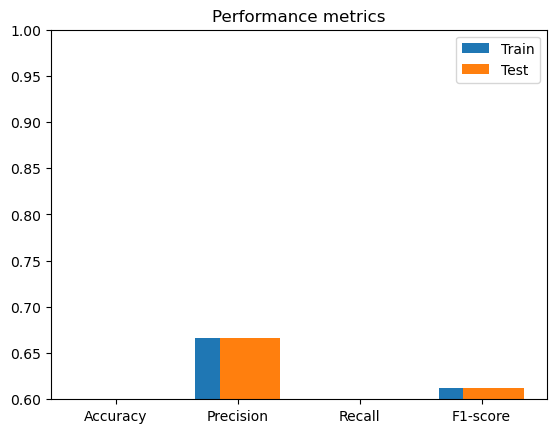

In [76]:
plot_bar_performance_metrics(y_train_true=y_true, y_test_true=y_true, y_train_pred=y_pred, y_test_pred=y_pred, average="weighted")